## Spatial discontinuity in soccer - random outcomes and evaluations

Motivation: https://www.youtube.com/watch?v=e2ClS5M1l1Y

This study aims to test whether minor, arguably random, differences in performance that result in different outcomes lead to unproportioned gaps in evaluations. If such gaps exist, one could take advantage of them by buying/selling undervalued/overvalued players.

For that, I use soccer data and take advantage of the spatial discontinuity around the goal border in a Regression Discontinuity Design (RDD). In this framework, scoring a close goal is thought of as the treatment, whereas hitting the post (missing) is the
control. 

Thus, the identifying assumption is that conditional on shooting close to the goal border, scoring or missing is random. I estimate the causal effect of the treatment (having a goal listed) on the evaluations of players' performance as reflected in their match ratings (assigned by WhoScored?).

In [1]:
# https://statsbomb.com/news/statsbomb-release-free-messi-data-all-seasons-from-2004-05-2020-21-now-available/
# git statsbombpy -- https://github.com/statsbomb/statsbombpy
# pip install statsbombpy -- https://pypi.org/project/statsbomb/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
from statsbombpy import sb
from scipy.stats import norm
sns.set()
pd.set_option('display.max_columns', 100)

#### StatsBomb events data (API calls)

In [ ]:
# All available La-Liga (Barca matches from 04-21 in which messi played)
comp_list = sb.competitions()
comp_list = comp_list[comp_list.competition_id==11]
seas_id = comp_list['season_id']

# an event's dataframe contains all events from a specific game, its name is the match_id
matches = pd.DataFrame()
for i in seas_id:
    temp = sb.matches(competition_id=11, season_id=i)
    matches = matches.append(temp, ignore_index=True)
match_id = list(matches['match_id'])
print('Number of analyzed matches:', len(match_id))

# Create a dataframe of all shots taken in every match
shots = pd.DataFrame()
for i in match_id:
    temp = sb.events(match_id=i, split=True)["shots"]
    shots = shots.append(temp, ignore_index=True)
# Check that all data was downloaded - 520 different games
print('Number of analyzed matches:', shots['match_id'].nunique(), shots['match_id'].nunique()==len(match_id))
print('Number of shots:', len(shots))

In [3]:
# Export as csv
df = shots.merge(matches, on='match_id', suffixes=('_shot', '_match'))
df.to_csv('shots.csv', index=None, header=True)
df.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,shot,match_id,under_pressure,out,off_camera,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,data_version,shot_fidelity_version,xy_fidelity_version
0,239ee08b-69cb-4f4d-9689-6c7a80a7236e,509,1,00:10:41.536,10,41,Shot,15,Real Betis,From Throw In,Real Betis,Borja Iglesias Quintas,Center Forward,"[115.3, 34.7]",0.011460,"[a9ebdedd-7f5b-43ae-8e3c-17fd2f238ba0, e984d5a...","{'statsbomb_xg': 0.105435394, 'end_location': ...",3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2
1,28867324-e239-498c-ba87-d426f27861aa,817,1,00:17:31.710,17,31,Shot,30,Barcelona,From Free Kick,Barcelona,Ousmane Dembélé,Right Wing,"[103.3, 44.6]",0.029782,"[7030d96a-21a9-47d9-84d0-c7d96a5a7df5, b74c5a3...","{'statsbomb_xg': 0.08335477, 'end_location': [...",3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2
2,dfc8d4ed-f0ec-4ce0-afc1-1818b822620c,1107,1,00:24:36.155,24,36,Shot,36,Real Betis,Regular Play,Real Betis,Juan Miguel Jiménez López,Left Wing,"[114.0, 32.4]",0.487555,[11043fba-bfea-44c1-a161-3081593c91f0],"{'one_on_one': True, 'statsbomb_xg': 0.2120483...",3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2
3,631f274d-f88e-49df-8566-cf10072c0f43,1240,1,00:27:57.202,27,57,Shot,42,Barcelona,From Corner,Barcelona,Clément Lenglet,Left Center Back,"[113.8, 42.7]",0.419639,[2f708f6d-5891-4d64-acac-785c956b96d1],"{'statsbomb_xg': 0.26389658, 'end_location': [...",3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2
4,bf67c762-daf8-4f83-ae23-fee462132626,1722,1,00:37:48.928,37,48,Shot,65,Real Betis,Regular Play,Real Betis,Borja Iglesias Quintas,Center Forward,"[111.7, 42.4]",0.509266,[12c5d1f9-6448-452f-a505-1b7b8881e760],"{'statsbomb_xg': 0.4367328, 'end_location': [1...",3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2


In [ ]:
# Participation data
starters = pd.DataFrame()
subs = pd.DataFrame()
for i in match_id:
    temp = sb.events(match_id=i, split=True, fmt = "dataframe")
    starters = starters.append(temp["starting_xis"], ignore_index=True)
    subs = subs.append(temp["substitutions"], ignore_index=True)

In [6]:
# Check that all data was downloaded - 520 different games
print(starters['match_id'].nunique())
print(subs['match_id'].nunique())
print(len(match_id))

# Starting lineup per match dataframe
temp = starters.loc[starters["team"]=='Barcelona']['tactics'].apply(pd.Series)
x = temp['lineup'].apply(pd.Series)
start_per_game = pd.DataFrame()
for i in range(0,11):
    temp = x[i].apply(pd.Series)
    y = temp['player'].apply(pd.Series)
    start_per_game[i]= y['name']
start_per_game['match_id'] = starters['match_id']

# Subs lineup per match dataframe
sub_list = pd.DataFrame()
temp = subs.loc[subs["team"]=='Barcelona']
sub_list['off'] = temp['player']
x = temp['substitution'].apply(pd.Series)
x = x['replacement'].apply(pd.Series)
sub_list['on'] = x['name']
sub_list['match_id'] = temp['match_id']
sub_list['sub_num'] = sub_list.groupby('match_id').cumcount()+1
# reshaping so each row is a match and each column is a player (cells contain player names)
x = sub_list.pivot(index="match_id", columns='sub_num', values='on').reset_index()
# Participating players by match
participation_df = start_per_game.merge(x, how='left', on='match_id', suffixes=('', '_sub'))
participation_df['date']= participation_df.merge(matches, on='match_id')[['match_date']] #adding date
participation_df.to_csv('participation.csv', index=None)
participation_df

520
520
520


,0,1,2,3,4,5,6,7,8,9,10,match_id,1_sub,2_sub,3_sub,4_sub,5_sub,date
0,Marc-André ter Stegen,Óscar Mingueza García,Ronald Federico Araújo da Silva,Clément Lenglet,Jordi Alba Ramos,Sergio Busquets i Burgos,Miralem Pjanić,Ricard Puig Martí,Ousmane Dembélé,Martin Braithwaite Christensen,Antoine Griezmann,3773631,Frenkie de Jong,Pedro González López,Lionel Andrés Messi Cuccittini,Francisco António Machado Mota de Castro Trincão,Samuel Yves Umtiti,2021-02-07
1,Marc-André ter Stegen,Óscar Mingueza García,Clément Lenglet,Samuel Yves Umtiti,Sergino Dest,Jordi Alba Ramos,Sergio Busquets i Burgos,Frenkie de Jong,Pedro González López,Lionel Andrés Messi Cuccittini,Antoine Griezmann,3773665,Ousmane Dembélé,Martin Braithwaite Christensen,Moriba Kourouma Kourouma,Ricard Puig Martí,Héctor Junior Firpo Adames,2021-03-06
2,Marc-André ter Stegen,Óscar Mingueza García,Ronald Federico Araújo da Silva,Clément Lenglet,Sergino Dest,Jordi Alba Ramos,Sergio Busquets i Burgos,Frenkie de Jong,Lionel Andrés Messi Cuccittini,Pedro González López,Ousmane Dembélé,3773497,Antoine Griezmann,Sergi Roberto Carnicer,Moriba Kourouma Kourouma,Martin Braithwaite Christensen,Francisco António Machado Mota de Castro Trincão,2021-04-10
3,Marc-André ter Stegen,Sergino Dest,Ronald Federico Araújo da Silva,Clément Lenglet,Jordi Alba Ramos,Sergio Busquets i Burgos,Frenkie de Jong,Antoine Griezmann,Philippe Coutinho Correia,Martin Braithwaite Christensen,Lionel Andrés Messi Cuccittini,3773660,Pedro González López,Francisco António Machado Mota de Castro Trincão,Samuel Yves Umtiti,NaN,NaN,2020-12-13
4,Norberto Murara Neto,Sergi Roberto Carnicer,Gerard Piqué Bernabéu,Clément Lenglet,Jordi Alba Ramos,Sergio Busquets i Burgos,Frenkie de Jong,Antoine Griezmann,Philippe Coutinho Correia,Anssumane Fati,Lionel Andrés Messi Cuccittini,3773593,Ousmane Dembélé,Pedro González López,Francisco António Machado Mota de Castro Trincão,Miralem Pjanić,NaN,2020-09-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,Víctor Valdés Arribas,Juliano Haus Belletti,Oleguer Presas Renom,Carles Puyol i Saforcada,Giovanni van Bronckhorst,Rafael Márquez Álvarez,Andrés Iniesta Luján,Anderson Luís de Souza,Ludovic Giuly,Ronaldo de Assis Moreira,"Samuel Eto""o Fils",68316,Thiago Motta,Lionel Andrés Messi Cuccittini,NaN,NaN,NaN,2005-05-01
516,Rubén Iván Martínez Andrade,Damià Abella Pérez,Carles Puyol i Saforcada,Oleguer Presas Renom,Giovanni van Bronckhorst,Xavier Hernández Creus,Anderson Luís de Souza,Andrés Iniesta Luján,Juliano Haus Belletti,Ronaldo de Assis Moreira,"Samuel Eto""o Fils",68315,Lionel Andrés Messi Cuccittini,NaN,NaN,NaN,NaN,2004-12-21
517,Víctor Valdés Arribas,Damià Abella Pérez,Carles Puyol i Saforcada,Oleguer Presas Renom,Giovanni van Bronckhorst,Rafael Márquez Álvarez,Anderson Luís de Souza,Xavier Hernández Creus,Andrés Iniesta Luján,Ronaldo de Assis Moreira,"Samuel Eto""o Fils",69153,Sergio Rodríguez García,Sylvio Mendes Campos Junior,Lionel Andrés Messi Cuccittini,NaN,NaN,2004-12-11
518,Víctor Valdés Arribas,Juliano Haus Belletti,Rafael Márquez Álvarez,Oleguer Presas Renom,Giovanni van Bronckhorst,Xavier Hernández Creus,Andrés Iniesta Luján,Anderson Luís de Souza,Ludovic Giuly,Ronaldo de Assis Moreira,Maximiliano Gastón López,68352,Lionel Andrés Messi Cuccittini,Thiago Motta,NaN,NaN,NaN,2005-04-17


### Pre-processing

In [2]:
df = pd.read_csv('shots.csv')

# Shot features
df['shot'] = df['shot'].map(eval) # string to dict
df = pd.concat([df.drop(['shot','type'], axis=1), df['shot'].apply(pd.Series)], axis=1) # nested dict to separate columns

# Shots' end location coordinates
temp = df['end_location'].apply(pd.Series)
df['x_end'],df['y_end'],df['z_end']  = temp[0], temp[1], temp[2]
df.drop('end_location', axis=1, inplace=True)

# Outcome (e.g., Goal), Type of play (e.g., free-kick), Body part used (e.g., head), Technique (e.g., volley)
nested_dicts = ['outcome', 'type', 'body_part', 'technique']
for i in nested_dicts:
    temp = df[i].apply(pd.Series)
    df = pd.concat([df, pd.get_dummies(temp['name'])], axis=1)
    df.drop(i, axis=1, inplace=True)
df.rename(columns={'Other': 'other_body_part'}, inplace=True)

# Match and player features
df['home_game'] = 1*(df['home_team']=='Barcelona') 
df['goal_diff'] = df['home_score'] - df['away_score']
df.loc[df.away_team == 'Barcelona', 'goal_diff'] = df['away_score'] - df['home_score']
# Dummy for position
df['pos_def'] = 1*( (df['position']=='Center Back') | (df['position']=='Left Back') | (df['position']=='Right Back') |  (df['position']=='Left Center Back') | (df['position']=='Right Center Back') |(df['position']=='Left Wing Back') | (df['position']=='Right Wing Back') | (df['position']=='Center Defensive Midfield') | (df['position']=='Left Defensive Midfield') | (df['position']=='Right Defensive Midfield'))
df['pos_mid'] = 1*( (df['position']=='Left Center Midfield') | (df['position']=='Right Center Midfield') |  (df['position']=='Left Midfield') | (df['position']=='Right Midfield') )
df['pos_fwd'] = 1*( (df['position']=='Center Forward') | (df['position']=='Right Center Forward') | (df['position']=='Left Center Forward') | (df['position']=='Center Attacking Midfield') | (df['position']=='Right Attacking Midfield') |  (df['position']=='Left Attacking Midfield') |  (df['position']=='Left Wing') | (df['position']=='Right Wing')  )

df.head()

,id,index,period,timestamp,minute,second,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,match_id,under_pressure,out,off_camera,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,data_version,shot_fidelity_version,xy_fidelity_version,statsbomb_xg,key_pass_id,first_time,freeze_frame,one_on_one,aerial_won,deflected,open_goal,saved_off_target,saved_to_post,redirect,follows_dribble,x_end,y_end,z_end,Blocked,Goal,Off T,Post,Saved,Saved Off Target,Saved to Post,Wayward,Corner,Free Kick,Open Play,Penalty,Head,Left Foot,other_body_part,Right Foot,Backheel,Diving Header,Half Volley,Lob,Normal,Overhead Kick,Volley,home_game,goal_diff,pos_def,pos_mid,pos_fwd
0,239ee08b-69cb-4f4d-9689-6c7a80a7236e,509,1,00:10:41.536,10,41,15,Real Betis,From Throw In,Real Betis,Borja Iglesias Quintas,Center Forward,"[115.3, 34.7]",0.011460,"['a9ebdedd-7f5b-43ae-8e3c-17fd2f238ba0', 'e984...",3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2.0,0.105435,221a84a8-9e23-4e66-901e-21cf81390905,True,"[{'location': [108.6, 10.9], 'player': {'id': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.9,34.9,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
1,28867324-e239-498c-ba87-d426f27861aa,817,1,00:17:31.710,17,31,30,Barcelona,From Free Kick,Barcelona,Ousmane Dembélé,Right Wing,"[103.3, 44.6]",0.029782,"['7030d96a-21a9-47d9-84d0-c7d96a5a7df5', 'b74c...",3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2.0,0.083355,11b72274-4552-4203-88b2-5585ffa7617c,True,"[{'location': [114.9, 41.4], 'player': {'id': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.2,44.5,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
2,dfc8d4ed-f0ec-4ce0-afc1-1818b822620c,1107,1,00:24:36.155,24,36,36,Real Betis,Regular Play,Real Betis,Juan Miguel Jiménez López,Left Wing,"[114.0, 32.4]",0.487555,['11043fba-bfea-44c1-a161-3081593c91f0'],3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2.0,0.212048,104d1ac2-6d52-4608-b01e-2a14accdeaa0,NaN,"[{'location': [96.2, 46.2], 'player': {'id': 2...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,34.8,1.6,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
3,631f274d-f88e-49df-8566-cf10072c0f43,1240,1,00:27:57.202,27,57,42,Barcelona,From Corner,Barcelona,Clément Lenglet,Left Center Back,"[113.8, 42.7]",0.419639,['2f708f6d-5891-4d64-acac-785c956b96d1'],3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2.0,0.263897,32a75b2e-8fa4-4cd8-b8ed-7906c73f7d72,NaN,"[{'location': [94.9, 11.9], 'player': {'id': 2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,34.6,1.3,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
4,bf67c762-daf8-4f83-ae23-fee462132626,1722,1,00:37:48.928,37,48,65,Real Betis,Regular Play,Real Betis,Borja Iglesias Quintas,Center Forward,"[111.7, 42.4]",0.509266,['12c5d1f9-6448-452f-a505-1b7b8881e760'],3773631,NaN,NaN,NaN,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,available,2021-02-24T16:46:37.954522,2022-08-04T12:00,22,Regular Season,Estadio Benito Villamarín,NaN,1.1.0,2,2.0,0.436733,b61c8710-fd23-4bb0-872a-cd43438baca8,True,"[{'location': [111.8, 61.3], 'player': {'id': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,42.2,0.3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1


## RDD assumptions

For a valid RDD (i.e., causal interpretation), three main assumptions should be verified:

    1. There exists a cutoff point (goal frame) where very small movements determine success or failure (goal or miss).
    
    2. Individuals have no control on the shots' outcome within that margin (i.e., shots very close to the goal frame).
    
    3. The shots in each group (marginal goals and misses) are similar in all aspects but their outcome.

#### Assumption 1: spatial discontinuity

Text(30.5, 0.5, 'Meters above Ground')

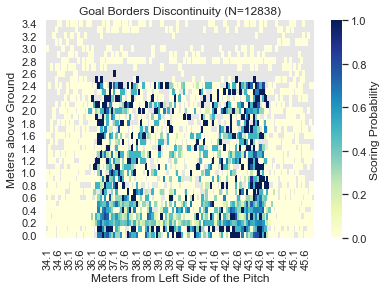

In [3]:
# Heatmap of end-locations' scoring probability
df_hm = df.groupby(['y_end','z_end'], as_index=False)['Goal'].mean() # prob to score per 10cm*10cm coordinates
df_hm = df_hm.loc[(df_hm['y_end']>34) & (df_hm['y_end']<46) & (df['Penalty']==0)]
df_hm = df_hm.loc[(df_hm['z_end']<3.5)]
df_hm = df_hm.pivot("z_end", "y_end", "Goal") # columns are y, rows are z, values are goal prob

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig = plt.figure()
ax = sns.heatmap(df_hm, cmap="YlGnBu", cbar_kws={'label': 'Scoring Probability'})
ax.invert_yaxis()
ax.set_title(f'Goal Borders Discontinuity (N={len(df)})')
ax.set_xlabel('Meters from Left Side of the Pitch')
ax.set_ylabel('Meters above Ground')
#fig.savefig('heatmap.pdf', bbox_inches="tight")

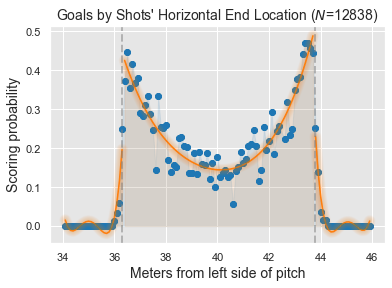

In [4]:
# Cutoff identification - probability to score per horizontal location
df_mean = df.groupby('y_end', as_index=False)['Goal'].mean()
df_mean = df_mean.loc[(df_mean['y_end']>34) & (df_mean['y_end']<46)] # drop far-off shots

# allowing smoothing function to change across regions
df_mean1 = df_mean.loc[(df_mean['y_end']>36.3) & (df_mean['y_end']<43.8)]
df_mean2 = df_mean.loc[(df_mean['y_end']<36.4)]
df_mean3 = df_mean.loc[(df_mean['y_end']>43.7)]

# plot 
plt.plot(df_mean['y_end'],df_mean['Goal'],'o', color='tab:blue')
for region in [df_mean1, df_mean2, df_mean3]:
    x = region['y_end']
    y = region['Goal']
    z = np.polyfit(x, y, deg=4)
    f = np.poly1d(z)
    y_new = f(x)
    plt.plot(x, y_new, color='tab:orange')

mplcyberpunk.add_glow_effects()
plt.xlabel("Meters from left side of pitch", size=14)
plt.ylabel("Scoring probability", size=14)
plt.title(f"Goals by Shots' Horizontal End Location ($N$={len(df)})", size=14)
plt.axvline(x=36.3, alpha=0.5, c='tab:grey', linestyle='--', linewidth=2)
plt.axvline(x=43.8, alpha=0.5, c='tab:grey', linestyle='--', linewidth=2)
#plt.savefig('horizontal_cutoff.pdf', bbox_inches="tight")

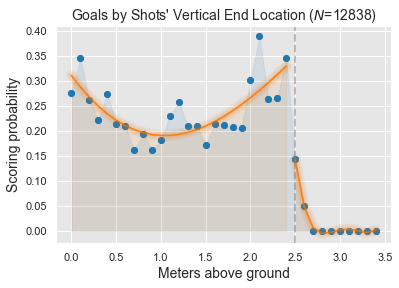

In [5]:
# Cutoff identification - probability to score per vertical location
df_mean = df.groupby('z_end', as_index=False)['Goal'].mean()
df_mean = df_mean.loc[(df_mean['z_end']<3.5)] # drop far-off shots

# allowing smoothing function to change across regions
df_mean1 = df_mean.loc[(df_mean['z_end']<2.5)]
df_mean2 = df_mean.loc[(df_mean['z_end']>=2.5)]

# plot 
plt.plot(df_mean['z_end'],df_mean['Goal'],'o', color='tab:blue')
for region in [df_mean1, df_mean2]:
    x = region['z_end']
    y = region['Goal']
    z = np.polyfit(x, y, deg=4)
    f = np.poly1d(z)
    y_new = f(x)
    plt.plot(x, y_new, color='tab:orange')

mplcyberpunk.add_glow_effects()
plt.xlabel("Meters above ground", size=14)
plt.ylabel("Scoring probability", size=14)
plt.title(f"Goals by Shots' Vertical End Location ($N$={len(df)})", size=14)
plt.axvline(x=2.5, alpha=0.5, c='tab:grey', linestyle='--', linewidth=2)
#plt.savefig('vertical_cutoff.pdf', bbox_inches="tight")

The graphs above show the spatial discontiuity, where very small changes to shots' end locations around the cutoff (vertical dashed line) greatly affect their scoring probability, leading to a definition of marginal goals and marginal misses.

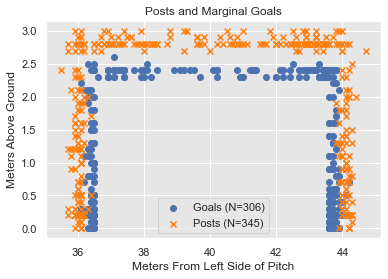

In [6]:
# Close goal definition (20cm from the cutoff to get balanced group sizes)
df['close_goal'] = (((df['y_end']>=43.6) | (df['y_end']<=36.5) | (df['z_end']>=2.3)) & (df['Goal']==1) & (df['Penalty']==0))*1

posts = df.loc[df['Post']==1]
close_goals = df.loc[df['close_goal']==1]
# scatter plot
fig = plt.figure()
plt.scatter(close_goals['y_end'], close_goals['z_end'], label=f"Goals (N={len(close_goals)})")
plt.scatter(posts['y_end'], posts['z_end'], marker="x", label=f"Posts (N={len(posts)})", color='tab:orange')
plt.xlabel('Meters From Left Side of Pitch')
plt.ylabel('Meters Above Ground')
plt.title('Posts and Marginal Goals')
plt.legend(loc=8)
mplcyberpunk.add_glow_effects()
#fig.savefig('goals_and_posts.pdf', bbox_inches="tight")

#### Assumption 2: the outcome is not correlated with ability

Text(0.5, 1.0, 'Ratio and Goals per Match by Player')

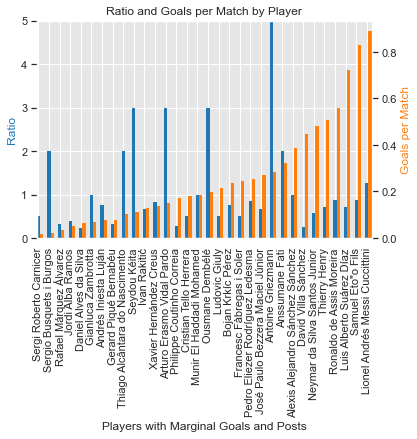

In [7]:
# Marginal goals and misses per game by Braca players
df_bp = df.loc[df['possession_team']=='Barcelona'] 
df_bp = df_bp.groupby('player', as_index=False)[['close_goal','Post','Goal']].sum() # Aggregates across all Messi matches

df_bp = df_bp.loc[(df_bp['close_goal']>0) & (df_bp['Post']>0)].copy()
player_list = df_bp['player'].sort_values()
# Number of matches per relevant players
participation_df = pd.read_csv('participation.csv')
x = participation_df.apply(pd.value_counts).fillna(0)
x['names'] = x.index
matches_num = x.loc[x['names'].isin(player_list)]   
matches_num = matches_num.drop(['date', 'match_id', 'names'], axis=1)
matches_num = matches_num.sum(axis=1).reset_index()
matches_num = matches_num.sort_values(by=[0])
# Feature construction
df_bp = df_bp.merge(matches_num,  left_on='player', right_on='index')
df_bp['ratio'] = (df_bp['close_goal']) / (df_bp['Post'])
df_bp['goals_per_match'] = (df_bp['Goal']) / (df_bp[0])
# Plot
df_bp.sort_values(by='goals_per_match', inplace=True) # sort players by goals per match
y_pos = np.arange(len(df_bp['player'])) # players on X-axis
ax = plt.subplot(111)
w=0.3
ax.set_ylabel('Ratio', color = 'tab:blue')
ax.autoscale(tight=True)
plt.xticks(y_pos, df_bp['player'], rotation='vertical')
ax.set_xlabel('Players with Marginal Goals and Posts')
ax2 = ax.twinx()
ax2.bar(y_pos+w, df_bp['goals_per_match'], width=w, align='center', label='Goals per Match', color = 'tab:orange', edgecolor = "none")
ax.bar(y_pos, df_bp['ratio'], width=w, align='center', label='Ratio', color = 'tab:blue', edgecolor = "none")
ax2.set_ylabel('Goals per Match', color = 'tab:orange')
ax2.grid(False)
ax.set_title('Ratio and Goals per Match by Player')
#ax.figure.savefig('players_ratio.pdf', bbox_inches="tight")

The graph above shows that more skilled shooters (i.e., the strikers on the right hand side of the graph) do not have a higher marginal-goals to marginal-misses ratio compared to less skilled shooters (i.e., players with low numbers of goals per match). That implies that the assignment to my treatment and control groups is not correlated with skills.

#### Assumption 3: balanced treatment and control groups

In [8]:
# Compare shots that ended up as marginal goals versus marginal misses
df_bp = df.loc[df['possession_team']=='Barcelona'].copy()

comparison = df_bp.groupby(['close_goal','Post'],as_index=False).mean()
comparison['Group'] = 'Marginal Goal'
comparison.loc[(comparison['Post']==1),'Group'] = 'Marginal Miss'
comparison = comparison.loc[(comparison['Post']==1) | (comparison['close_goal']==1)]
comparison[['Group','statsbomb_xg', 'home_game', 'goal_diff', 'pos_def', 'pos_mid', 'pos_fwd', 'minute', 'duration',
            'Penalty','Free Kick','Open Play', 'Head', 'Left Foot', 'Right Foot', 'Normal', 'Volley', 'Half Volley']]

,Group,statsbomb_xg,home_game,goal_diff,pos_def,pos_mid,pos_fwd,minute,duration,Penalty,Free Kick,Open Play,Head,Left Foot,Right Foot,Normal,Volley,Half Volley
1,Marginal Miss,0.155950,0.561753,2.131474,0.167331,0.127490,0.705179,49.235060,0.826885,0.003984,0.143426,0.848606,0.115538,0.370518,0.513944,0.820717,0.039841,0.095618
2,Marginal Goal,0.193957,0.572034,2.779661,0.118644,0.152542,0.724576,48.559322,0.900543,0.000000,0.097458,0.902542,0.076271,0.500000,0.419492,0.834746,0.042373,0.059322


In [9]:
# Examine whether differences are statistically significant
from scipy import stats
cols = ['statsbomb_xg', 'home_game', 'goal_diff', 'pos_def', 'pos_mid', 'pos_fwd', 'minute', 'duration','Penalty','Free Kick',
        'Open Play', 'Head', 'Left Foot', 'Right Foot', 'Normal', 'Volley', 'Half Volley']
for col in cols:
    A = df_bp[df_bp['Post']==1][col].values.tolist()
    B = df_bp[df_bp['close_goal']==1][col].values.tolist()
    t_check=stats.ttest_ind(A,B)
    t_check
    alpha=0.05
    if(t_check[1]<alpha):
        print(f'{col}: different')

statsbomb_xg: different
goal_diff: different
duration: different
Left Foot: different
Right Foot: different


Close goals (compared to close misses) come from slightly better situations (higher xG), they are longer in duration (mechanically), taken more with the left foot than right foot (might be due to Messi's representation in the dataset), and their matches end with higher score differences (as one would expect if a goal was randomly canceled).

### Dependent variable (labels)

In [10]:
# Export list of players per match and manually add ratings from WhoScored?
participation_df = pd.read_csv('participation.csv')
participation_df.rename(columns={'1_sub': '11', '2_sub': '12', '3_sub':'13', '4_sub':'14', '5_sub':'15'}, inplace=True)
long = pd.melt(participation_df, id_vars=['match_id','date'], value_vars=['0','1','2','3','4','5','6','7','8','9','10',
                                                                          '11','12','13','14','15'])
long['variable'] = long['variable'].astype(int)
long.sort_values(by=['date','variable']).to_csv('players_matches.csv', index=False)

# Load ratings from WhoScored?
ratings_df = pd.read_csv('players_ratings.csv')
ratings_df = ratings_df.loc[ratings_df['player'].isna()==False].copy()
ratings_df.fillna(0,inplace=True)
ratings_df['pos_def'] = 1*(ratings_df['position']<=4)
ratings_df['pos_mid'] = 1*((ratings_df['position']>4) & (ratings_df['position']<=7))
ratings_df['pos_fwd'] = 1*((ratings_df['position']>7) & (ratings_df['position']<=10))
ratings_df['sub'] = 1*(ratings_df['position']>10)
ratings_df

,match_id,date,position,player,rating,goals,assists,yellow,red,miss_post,error,save,pos_def,pos_mid,pos_fwd,sub
0,69229,12/09/2009,0,Víctor Valdés Arribas,7.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,69229,12/09/2009,1,Carles Puyol i Saforcada,7.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,69229,12/09/2009,2,Gerard Piqué Bernabéu,7.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,69229,12/09/2009,3,Dmytro Chygrynskiy,6.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
4,69229,12/09/2009,4,Eric-Sylvain Bilal Abidal,8.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,3773457,16/05/2021,11,Ricard Puig Martí,6.56,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1
6572,3773457,16/05/2021,12,Sergino Dest,6.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
6573,3773457,16/05/2021,13,Martin Braithwaite Christensen,5.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
6574,3773457,16/05/2021,14,Francisco António Machado Mota de Castro Trincão,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1


count    5729.000000
mean        7.155047
std         0.932546
min         3.280000
25%         6.450000
50%         7.010000
75%         7.640000
max        10.000000
Name: rating, dtype: float64


<AxesSubplot:xlabel='rating', ylabel='Count'>

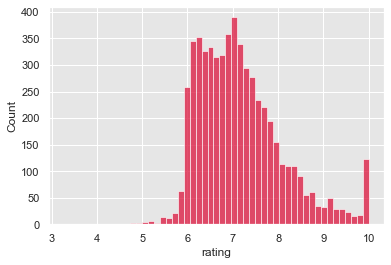

In [11]:
# Explore distribution and outliers
print(ratings_df['rating'].describe())
sns.histplot(ratings_df['rating'], color='crimson') # distribution (hist) plot

Players' ratings exhibit a log-normal distribution ranging between 3.3 and 10. However, it is censored from above (can't get more than 10), requiring a Tobit model analysis to avoid biased estimates.

### Features

In [12]:
df_bp = df.loc[df['possession_team']=='Barcelona'].copy()
df_bp['off_target'] = df_bp['Off T'] + df_bp['Wayward'] + df_bp['Post'] + df_bp['Saved Off Target']
df_bp['on_target'] = df_bp['Goal'] + df_bp['Saved'] + df_bp['Saved to Post']
df_bp ['penalty_score'] = 1*((df_bp['Penalty']==1) & (df_bp['Goal']==1))
df_bp ['penalty_miss'] = 1*((df_bp['Penalty']==1) & (df_bp['Goal']==0))
df_bp = df_bp.groupby(['player','match_id'],as_index=False).agg({'statsbomb_xg':'sum','off_target':'sum','on_target':'sum',
                                                                 'penalty_score':'sum','penalty_miss':'sum','close_goal':'sum', 
                                                                 'Post':'sum'})
df_bp[['statsbomb_xg', 'off_target', 'on_target','penalty_score', 'penalty_miss', 'close_goal', 'Post']].describe()

,statsbomb_xg,off_target,on_target,penalty_score,penalty_miss,close_goal,Post
count,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
mean,0.319863,0.797222,0.975278,0.024444,0.006667,0.065556,0.069722
std,0.402338,0.867423,1.118785,0.161482,0.081388,0.260660,0.275669
min,0.006635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.051156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.151387,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.433841,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.246030,8.000000,7.000000,2.000000,1.000000,2.000000,3.000000


In [13]:
# Merge features and labels data 
analysis = ratings_df.merge(df_bp, on=['player','match_id'], how='left')
analysis.fillna(0, inplace=True)
analysis['goals_reg'] = analysis['goals'] - analysis['close_goal'] # to separate coefficients
analysis['match_pos'] = analysis['match_id'].astype(str) + 'def' # Setting match-position Fixed Effects
analysis.loc[analysis['pos_mid']==1,'match_pos'] = analysis['match_id'].astype(str) + 'mid'
analysis.loc[analysis['pos_fwd']==1,'match_pos'] = analysis['match_id'].astype(str) + 'fwd'
analysis.loc[analysis['sub']==1,'match_pos'] = 'sub'
players_to_drop = pd.DataFrame(analysis['player'].value_counts()).reset_index() # Setting player FE
players_to_drop = list(players_to_drop.loc[players_to_drop['player']<5, 'index']) # enough within-player variation
analysis.loc[analysis['player'].isin(players_to_drop),'player'] = 'Other'
analysis.to_csv('ratings_analysis.csv',index=False)
analysis

,match_id,date,position,player,rating,goals,assists,yellow,red,miss_post,error,save,pos_def,pos_mid,pos_fwd,sub,statsbomb_xg,off_target,on_target,penalty_score,penalty_miss,close_goal,Post,goals_reg,match_pos
0,69229,12/09/2009,0,Víctor Valdés Arribas,7.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69229def
1,69229,12/09/2009,1,Carles Puyol i Saforcada,7.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69229def
2,69229,12/09/2009,2,Gerard Piqué Bernabéu,7.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.067432,0.0,1.0,0.0,0.0,0.0,0.0,0.0,69229def
3,69229,12/09/2009,3,Dmytro Chygrynskiy,6.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69229def
4,69229,12/09/2009,4,Eric-Sylvain Bilal Abidal,8.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69229def
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,3773457,16/05/2021,11,Ricard Puig Martí,6.56,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sub
5725,3773457,16/05/2021,12,Sergino Dest,6.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.017459,1.0,0.0,0.0,0.0,0.0,0.0,0.0,sub
5726,3773457,16/05/2021,13,Martin Braithwaite Christensen,5.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.129961,1.0,0.0,0.0,0.0,0.0,0.0,0.0,sub
5727,3773457,16/05/2021,14,Francisco António Machado Mota de Castro Trincão,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sub


### Tobit Regressions

To deal with the censored nature of ratings, I take a latent variable approach in which the observed rating ($y$) follows the following function: 
    
$y=min(y*,10)$ where $y*$ is the true rating.

Additionaly, further cleaning the RDD identification, I introduce player and match-position Fixed Effects, so that the identified effects come from within player (i.e., average across all matches of a player) and within match-position (e.g., across the average ratings of all midfielders in a particular match).

In [1]:
# Change kernel to R and reload data
df <- read.csv("ratings_analysis.csv")
df$match_id <- as.factor(df$match_id)
df$match_pos <- as.factor(df$match_pos)
df$player <- as.factor(df$player)

In [3]:
library(AER)

tobit = AER::tobit(rating ~ goals_reg + close_goal + Post + assists + yellow + red + error + save + statsbomb_xg + off_target + 
                   on_target + penalty_score + penalty_miss + C(player) + C(match_pos), 
                   data=df, left=0, right=10, robust=TRUE)
summary(tobit)


Call:
AER::tobit(formula = rating ~ goals_reg + close_goal + Post + 
    assists + yellow + red + error + save + statsbomb_xg + off_target + 
    on_target + penalty_score + penalty_miss + C(player) + C(match_pos), 
    left = 0, right = 10, data = df, robust = TRUE)

Observations:
         Total  Left-censored     Uncensored Right-censored 
          5729              0           5616            113 

Coefficients:
                                                              Estimate
(Intercept)                                                  6.662e+00
goals_reg                                                    7.731e-01
close_goal                                                   8.160e-01
Post                                                         2.701e-01
assists                                                      6.063e-01
yellow                                                      -1.693e-01
red                                                         -1.198e+00
error      

In [6]:
# Test the hypothesis that close goal and close miss have similar impact on rating
linearHypothesis(tobit, "close_goal = Post")

Res.Df,Df,Chisq,Pr(>Chisq)
4403,NA,NA,NA
4402,1,123.1024,1.324327e-28


Given arguably identical actions by the player, being randomly assigned to scoring a goal (versus just missing), increases players match ratings by over half a point (0.549, $p<.01$).